In [1]:
import pandas as pd
import numpy as np
import holidays
import main
import math
import pmdarima as pm

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')

## WEEKDAY AND HOLIDAYS

In [33]:
br_holidays = holidays.country_holidays('BR')  # this is a dict
mg_holidays = holidays.country_holidays('BR', subdiv='MG')  # this is a dict


In [ ]:
BR_H = list(map(lambda x: br_holidays.get(x), df['data_inversa']))
DF_H = list(map(lambda x: df_holidays.get(x), df['data_inversa']))

WEEKDAYS = list(map(lambda x: x.weekday(), df['data_inversa']))

#df['event_name'] = map(br_holidays.get(), df['data_inversa'])

In [ ]:
BR_H == DF_H


In [2]:
df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]

## Ajuste

In [ ]:
#for uf in np.unique(df_tcc['uf']):
#    print(uf)

In [57]:
train = df_tcc[(df_tcc['uf'] == 'MG') & (df_tcc['data_inversa'] <= '2023-02-28')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()

test = df_tcc[(df_tcc['uf'] == 'MG') & (df_tcc['data_inversa'] >= '2023-03-01')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()

In [92]:
WEEKDAYS = list(map(lambda x: x.weekday(), train.index))
MG_H = list(map(lambda x: 1 if mg_holidays.get(x) != None else 0, train.index))

exp_var1 = pd.DataFrame({'weekday': WEEKDAYS, 'is_holiday':MG_H})
exp_var1 = pd.get_dummies(exp_var1, columns=['weekday'], drop_first=True)


WEEKDAYS = list(map(lambda x: x.weekday(), test.index))
MG_H = list(map(lambda x: 1 if mg_holidays.get(x) != None else 0, test.index))

exp_var2 = pd.DataFrame({'weekday': WEEKDAYS, 'is_holiday':MG_H})
exp_var2 = pd.get_dummies(exp_var2, columns=['weekday'], drop_first=True)

In [102]:
model = pm.auto_arima(train.values, seasonal=True, m=7, X = np.array(exp_var1))

In [103]:
model.get_params

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [109]:
model.order

(3, 1, 1)

In [110]:
model.seasonal_order

(1, 0, 1, 7)

In [104]:
forecasts = model.predict(test.shape[0], X = np.array(exp_var2))

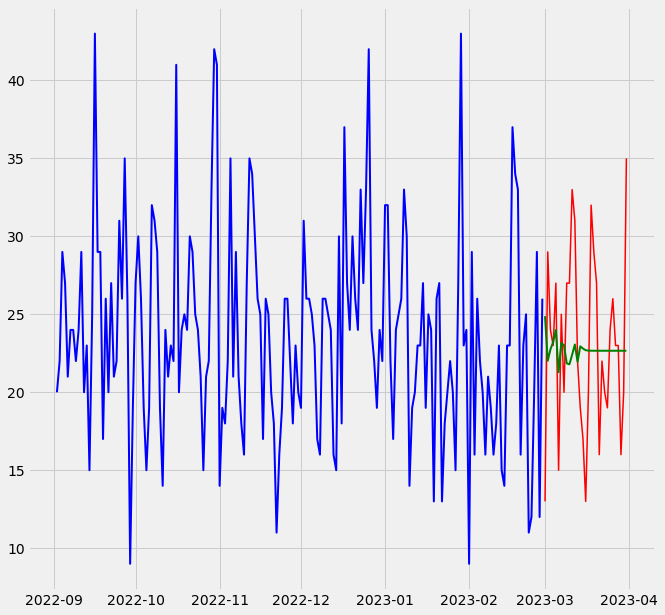

In [79]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(train[-180:], c='blue',linewidth=2)
plt.plot(test[-180:], c='red', linewidth=1.5)
plt.plot(np.array(test.index), forecasts, c='green', linewidth=2)


plt.show()

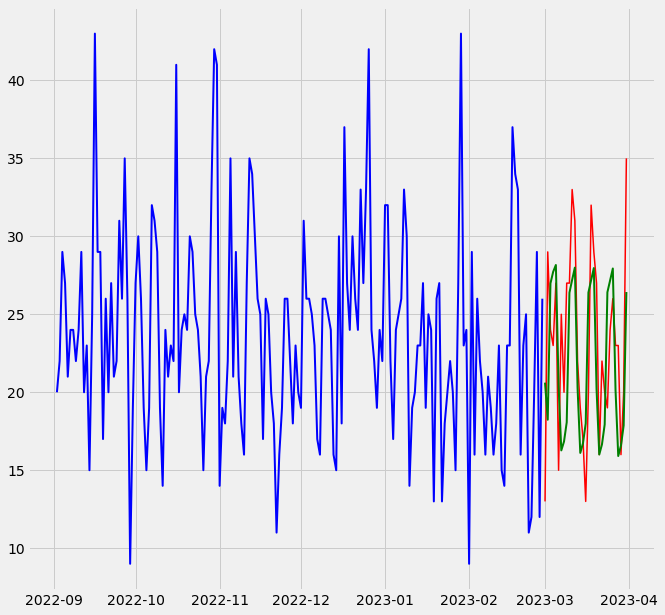

In [106]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(train[-180:], c='blue',linewidth=2)
plt.plot(test[-180:], c='red', linewidth=1.5)
plt.plot(np.array(test.index), forecasts, c='green', linewidth=2)


plt.show()

In [107]:
test.index

DatetimeIndex(['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20',
               '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
               '2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28',
               '2023-03-29', '2023-03-30', '2023-03-31'],
              dtype='datetime64[ns]', name='data_inversa', freq='D')